# *Name*: Raviteja Anumula Naga

# *Subject*: Computational Intelligence (502 - 2022 - ZS)

# *Project*: Semestral project - Aroplane Detection

**Note: Please use this google drive link to download h5 file of the models**

`VGG16 model`

https://drive.google.com/file/d/1-1mV3aGIVqfk6M9pLuKn9gUvymRIICGS/view?usp=share_link

`MobileNetV2 model`

https://drive.google.com/file/d/1VNm5ScNlDUAiOPH3Sopx2rV1iZGX3U8T/view?usp=share_link

**Importing useful Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Conv2D,Reshape,MaxPooling2D,Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

**Creating and assigning values to path variables where we have the data**

In [3]:
annot = '/content/drive/MyDrive/Data/A_Annot/'
path = '/content/drive/MyDrive/Data/A_Img'

**Checking if Data is loaded correctly**

airplane_083.jpg


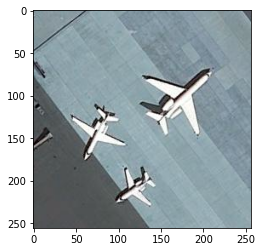

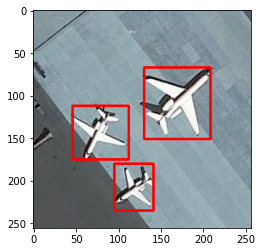

In [4]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

The SelectiveSearchSegmentation class is a method for object proposal generation, which means it can be used to identify possible regions of an image that contain objects. The createSelectiveSearchSegmentation function is a factory function that returns a new instance of the class.

In [5]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Building the possible bounding boxes of an image and displaying it

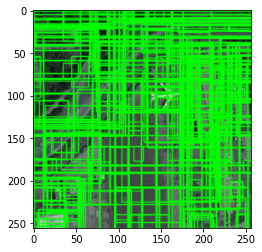

In [6]:
im = cv2.imread(os.path.join(path,"airplane_105.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

plt.imshow(imOut)

Creating train and test lists

In [7]:
train_images=[]
train_labels=[]

**intersection over union (IoU)**

Function get_iou calculates the intersection over union (IoU) between two bounding boxes.

A bounding box is represented as a dictionary with four keys: 'x1', 'y1', 'x2', 'y2', which correspond to the coordinates of the top-left and bottom-right corners of the bounding box.

The function first checks that the bounding boxes are valid, i.e., that their top-left corner has lower coordinates than their bottom-right corner. Then it calculates the coordinates of the intersection of the two bounding boxes. If the intersection is empty (i.e., if the right coordinate of the left bounding box is smaller than the left coordinate of the right bounding box, or if the bottom coordinate of the top bounding box is smaller than the top coordinate of the bottom bounding box), the function returns 0. Otherwise, it calculates the area of the intersection and the areas of the two bounding boxes, and returns the ratio of the intersection area to the sum of the two bounding box areas, minus the intersection area. This ratio, called the IoU, is a measure of the overlap between the two bounding boxes.

The function returns a floating point value between 0 and 1, inclusive, where 0 corresponds to no overlap and 1 corresponds to complete overlap.

In [8]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

**Train images and labels have been calculated and appended to the above created list**

In [9]:
z  = 0
for e,i in enumerate(os.listdir(annot)):
    try:
        if z <=500:
            
            if i.startswith("airplane"):
                filename = i.split(".")[0]+".jpg"
                # print(e,filename)
                image = cv2.imread(os.path.join(path,filename))
                df = pd.read_csv(os.path.join(annot,i))
                gtvalues=[]
                for row in df.iterrows():
                    x1 = int(row[1][0].split(" ")[0])
                    y1 = int(row[1][0].split(" ")[1])
                    x2 = int(row[1][0].split(" ")[2])
                    y2 = int(row[1][0].split(" ")[3])
                    gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                ss.setBaseImage(image)
                ss.switchToSelectiveSearchFast()
                ssresults = ss.process()
                imout = image.copy()
                counter = 0
                falsecounter = 0
                flag = 0
                fflag = 0
                bflag = 0
                for e,result in enumerate(ssresults):
                    if e < 2000 and flag == 0:
                        for gtval in gtvalues:
                            x,y,w,h = result
                            iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                            if counter < 30:
                                if iou > 0.70:
                                    timage = imout[y:y+h,x:x+w]
                                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                    train_images.append(resized)
                                    train_labels.append(1)
                                    counter += 1
                            else :
                                fflag =1
                            if falsecounter <30:
                                if iou < 0.3:
                                    timage = imout[y:y+h,x:x+w]
                                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                    train_images.append(resized)
                                    train_labels.append(0)
                                    falsecounter += 1
                            else :
                                bflag = 1
                        if fflag == 1 and bflag == 1:
                            # print("inside")
                            flag = 1
            z = z + 1
        else:
            break
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

**LabelBinarizer**

The MyLabelBinarizer class overrides the transform and inverse_transform methods of the parent LabelBinarizer class to add additional functionality. Specifically, it modifies the transform method to return a binary array that has an additional column representing the inverse of the original binary array. For example, if the original binary array is [1, 0, 1], the modified array returned by transform will be [[1, 0], [0, 1], [1, 0]].

The inverse_transform method is also overridden to handle this additional column when transforming the modified binary array back to the original categorical labels. If the y_type_ attribute of the MyLabelBinarizer instance is set to 'binary', the method will only use the first column of the binary array to determine the original labels. Otherwise, it will use the entire binary array as in the original LabelBinarizer implementation.

The threshold argument in the inverse_transform method is used to specify a threshold for determining the binary class labels. If it is not provided, the default value of 0.5 is used.

In [10]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

Creating instance of "MyLabelBinarizer" and transforing the train_labels

In [11]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(np.array(train_labels))

**Splitting the data**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(np.array(train_images),Y,test_size=0.10)


**ImageDataGenerator**

The ImageDataGenerator class, which is a tool for augmenting image data by applying random transformations. The first instance, trdata, is applied to the training data, and the second instance, tsdata, is applied to the test data.

The horizontal_flip, vertical_flip, and rotation_range arguments specify the types of transformations that should be applied. The horizontal_flip and vertical_flip arguments cause the generator to randomly flip the images horizontally or vertically. The rotation_range argument causes the generator to randomly rotate the images by a certain number of degrees.

The flow() method applies these transformations and returns a generator that can be used to iterate through the augmented data. The generators traindata and testdata can be used to obtain batches of augmented training and test data, respectively, for use in training and evaluating a model.

In [13]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train[0:10000], y=y_train[0:10000])

tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

**Pre-trained model VGG16**

VGG16 is a convolutional neural network model trained on the ImageNet dataset. It was developed by the Visual Geometry Group (VGG) at the University of Oxford and has been widely used for image classification tasks.

The VGG16 function creates a new model and loads the pre-trained weights from the ImageNet dataset. The weights parameter specifies which weights to use (in this case, 'imagenet') and the include_top parameter specifies whether to include the fully-connected layers at the top of the network (in this case, True).

The summary method prints a summary of the model, including the layers, the number of parameters in each layer, and the output shape of each layer. This can be useful for understanding the overall structure of the model and for debugging.

In [14]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 [==============================] - 14s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

**1st Model**

My model defines a new neural network model based on a pre-trained VGG16 model.

The first block of code sets the first 15 layers of the VGG16 model to be non-trainable, meaning that the weights in these layers will not be updated during training. This is done so that the pre-trained weights in these layers are not changed, and the lower-level features learned by the VGG16 model are preserved.

The second block of code adds 5 fully-connected (dense) layers with increasing number of units and ReLU activation to the model. These layers are added on top of the output of the last layer of the VGG16 model.

The third block of code adds a new fully-connected (dense) layer with 2 units and softmax activation to the model. This layer is used to produce the final prediction for the model.

The fourth block of code creates a new Model object using the VGG16 model's input layer and the new output layer containing the additional dense layers and the softmax layer. This new model is called model_final.

The fifth block of code defines an Adam optimizer with a learning rate of 0.0001, and compiles the model using a categorical cross-entropy loss function and accuracy metric.

Finally, the sixth block of code prints a summary of the model's architecture.

In [15]:
for layers in (vggmodel.layers)[:15]:
    #print(layers)
    layers.trainable = False

X= vggmodel.layers[-2].output

# Add 5 new fully-connected (Dense) layers with increasing number of units and ReLU activation
X = Dense(128, activation='relu')(X)
X = Dense(256, activation='relu')(X)
X = Dense(512, activation='relu')(X)
X = Dense(1024, activation='relu')(X)
X = Dense(2048, activation='relu')(X)

# Add a new fully-connected (Dense) layer with 2 units and softmax activation
predictions = Dense(2, activation="softmax")(X)

model_final = Model(inputs = vggmodel.input, outputs = predictions)


opt = Adam(lr=0.0001)

model_final.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**ModelCheckpoint and EarlyStopping**

ModelCheckpoint is a callback function in keras that saves the model during training. It is used to save the model after each epoch, if the validation loss has improved.

EarlyStopping is another callback function in keras that stops the training early if the validation loss has not improved for a certain number of epochs.

In [17]:
checkpoint = ModelCheckpoint("R-CNN-VGG.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

**Fitting the Model**

In [18]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 50, epochs= 200, validation_data= testdata, validation_steps=2, callbacks=[checkpoint, early])

<ipython-input-18-417984927ba0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 50, epochs= 200, validation_data= testdata, validation_steps=2, callbacks=[checkpoint, early])


Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8675
Epoch 1: val_loss improved from inf to 0.29832, saving model to R-CNN-VGG.h5
50/50 [==============================] - 44s 651ms/step - loss: 0.3370 - accuracy: 0.8675 - val_loss: 0.2983 - val_accuracy: 0.8750
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9231
Epoch 2: val_loss improved from 0.29832 to 0.13703, saving model to R-CNN-VGG.h5
50/50 [==============================] - 30s 603ms/step - loss: 0.2180 - accuracy: 0.9231 - val_loss: 0.1370 - val_accuracy: 0.9531
Epoch 3/200
50/50 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9439
Epoch 3: val_loss did not improve from 0.13703
50/50 [==============================] - 21s 404ms/step - loss: 0.1857 - accuracy: 0.9439 - val_loss: 0.1436 - val_accuracy: 0.9219
Epoch 4/200
50/50 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9362
Epoch 4: val_loss d

Uncomment these two lines to load the saved model

In [ ]:
# model = tf.keras.models.load_model('R-CNN-VGG.h5')
# print('Model loaded Sucessfully')

**Loss and Accuracy of 1st Model**

Avg Model Accuracy:  0.9479347359050404
Avg Model Loss:  0.1554159208229094
Avg Val Accuracy:  0.9474431818181818
Avg Val Loss:  0.15798943399479895


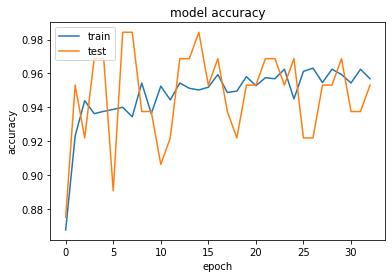

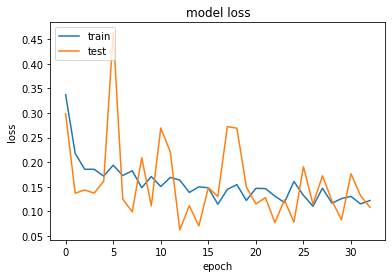

In [57]:
print('Avg Model Accuracy: ', np.mean(hist.history['accuracy']))
print('Avg Model Loss: ', np.mean(hist.history['loss']))
print('Avg Val Accuracy: ', np.mean(hist.history['val_accuracy']))
print('Avg Val Loss: ', np.mean(hist.history['val_loss']))
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Predicting using our model**

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step


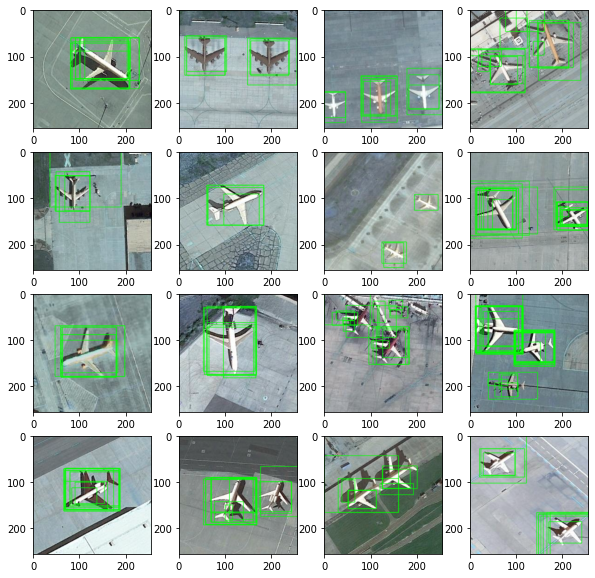

In [50]:
new_path = '/content/drive/MyDrive/Data/TestImages'
# create a figure with a grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
  file_name = 'Test{}.jpg'.format(i+1)  # generate the file name
  img = cv2.imread(os.path.join(new_path, file_name))  # read the image
  # img = cv2.imread(os.path.join(new_path, 'Test12.jpg'))        
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()
  imout = img.copy()
        
  for e, result in enumerate(ssresults):
    if e < 2000:
      x, y, w, h = result
      timage = imout[y:y+h, x:x+w]
      resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
      img = np.expand_dims(resized, axis = 0)
      out = model_final.predict(img)
                
      if out[0][0] > 0.7:
        cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
  ax.imshow(imout)  # plot the image in the current subplot
plt.imshow(imout)

**Pre-trained model MobileNetV2**

The MobileNetV2 model is a convolutional neural network (CNN) trained on the ImageNet dataset for image classification.

The weights='imagenet' argument specifies that the model should be initialized with weights trained on the ImageNet dataset. The include_top=True argument specifies that the model should include the fully-connected (dense) layers that were trained to perform the final classification. If include_top=False, then the model would exclude the top layers and only include the convolutional layers.

In [25]:
# Load the MobileNetV2 model, keeping the top layers (include_top=True) and ignoring the dense layers (weights='imagenet')
mobilenet = MobileNetV2(weights='imagenet', include_top=True)

# Print a summary of the model
mobilenet.summary()

14536120/14536120 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

**2nd Model**

The MobileNetV2 model is a pre-trained convolutional neural network (CNN) that was trained on a large dataset of images and can be used for image classification tasks.

First, the code sets the trainable attribute of all layers in the MobileNetV2 model to False, which means that these layers will not be updated during training. This is called "freezing" the layers, and it is often done when using a pre-trained model as a starting point for a new model, in order to preserve the knowledge that the pre-trained model has learned.

Next, the code extracts the output of the last layer of the MobileNetV2 model and uses it as the input for a new set of fully-connected (Dense) layers. These layers have increasing numbers of units and use the ReLU activation function. The output of the last layer is then passed through a final fully-connected layer with 2 units and a softmax activation function, which is used to predict the class probabilities for the two classes.

Finally, the code creates a new Model object with the MobileNetV2 model as the input and the new output layer as the output. The model is compiled with the Adam optimizer, a categorical cross-entropy loss function, and the accuracy metric. The model's summary is then printed to the console.

In [26]:
# Make the layers of the MobileNetV2 model untrainable
for layer in mobilenet.layers:
    layer.trainable = False

# Extract the output of the last layer of the MobileNetV2 model
X = mobilenet.layers[-2].output

# Add 5 new fully-connected (Dense) layers with increasing number of units and ReLU activation
X = Dense(128, activation='relu')(X)
X = Dense(256, activation='relu')(X)
X = Dense(512, activation='relu')(X)
X = Dense(1024, activation='relu')(X)
X = Dense(2048, activation='relu')(X)

# Add a new fully-connected (Dense) layer with 2 units and softmax activation
predictions = Dense(2, activation="softmax")(X)

# Create a new model with the MobileNetV2 model as the input and the new output layer as the output
model_final_1 = Model(inputs = mobilenet.input, outputs = predictions)

# Use the Adam optimizer with a learning rate of 0.0001
opt = Adam(lr=0.0001)

# Compile the model with a categorical cross-entropy loss function and accuracy metric
model_final_1.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

# Print a summary of the final model
model_final_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 block_4_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_3_project_BN[0][0]']     
                                                                                                  
 block_4_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_4_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_4_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_4_expand_BN[0][0]']      
                                                                                                  
 block_4_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_4_expand_relu[0][0]']    
 nv2D)                                                                                            
          

**ModelCheckpoint and EarlyStopping for 2nd Model**

In [27]:
checkpoint1 = ModelCheckpoint("R-CNN-MobileNetV2.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

**Fitting our 2nd Model**

In [28]:
hist1 = model_final_1.fit_generator(generator= traindata, steps_per_epoch= 50, epochs= 200, validation_data= testdata, validation_steps=2, callbacks=[checkpoint1, early1])

<ipython-input-28-1f7a63ff0dfa>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist1 = model_final_1.fit_generator(generator= traindata, steps_per_epoch= 50, epochs= 200, validation_data= testdata, validation_steps=2, callbacks=[checkpoint1, early1])


Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7837
Epoch 1: val_loss improved from inf to 0.36985, saving model to R-CNN-MobileNetV2.h5
50/50 [==============================] - 22s 386ms/step - loss: 0.4683 - accuracy: 0.7837 - val_loss: 0.3699 - val_accuracy: 0.8281
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.8288
Epoch 2: val_loss improved from 0.36985 to 0.28579, saving model to R-CNN-MobileNetV2.h5
50/50 [==============================] - 19s 371ms/step - loss: 0.4075 - accuracy: 0.8288 - val_loss: 0.2858 - val_accuracy: 0.8594
Epoch 3/200
50/50 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.8525
Epoch 3: val_loss improved from 0.28579 to 0.27122, saving model to R-CNN-MobileNetV2.h5
50/50 [==============================] - 18s 368ms/step - loss: 0.3446 - accuracy: 0.8525 - val_loss: 0.2712 - val_accuracy: 0.8906
Epoch 4/200
50/50 [==============================] - ETA

**Loss and Accuracy of 2nd Model**

Avg Model Accuracy:  0.8998789596803409
Avg Model Loss:  0.24215707659106894
Avg Val Accuracy:  0.8975515463917526
Avg Val Loss:  0.24427215201953023


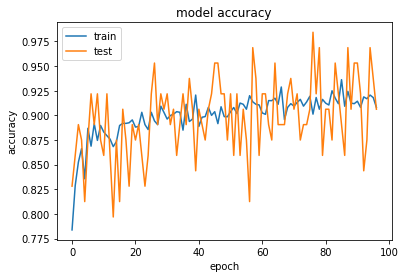

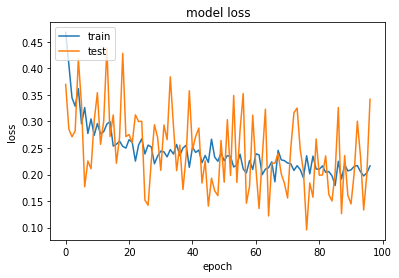

In [56]:
print('Avg Model Accuracy: ', np.mean(hist1.history['accuracy']))
print('Avg Model Loss: ', np.mean(hist1.history['loss']))
print('Avg Val Accuracy: ', np.mean(hist1.history['val_accuracy']))
print('Avg Val Loss: ', np.mean(hist1.history['val_loss']))
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Predicting same images using our 2nd Model

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step


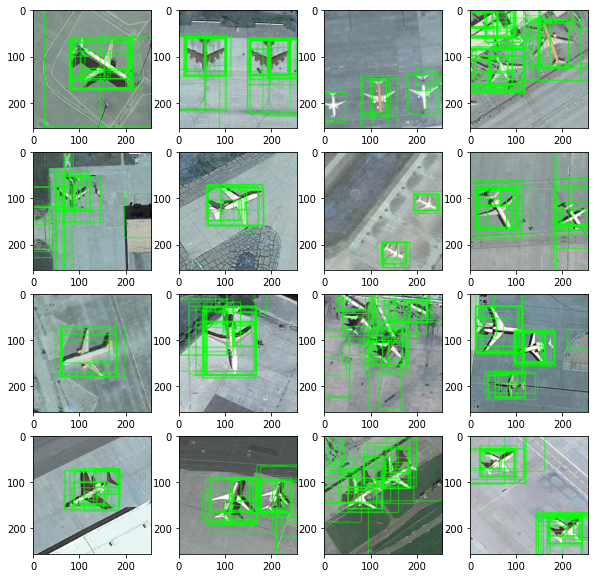

In [51]:
# create a figure with a grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
  file_name = 'Test{}.jpg'.format(i+1)  # generate the file name
  img = cv2.imread(os.path.join(new_path, file_name))  # read the image
  # img = cv2.imread(os.path.join(new_path, 'Test12.jpg'))        
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()
  imout = img.copy()
        
  for e, result in enumerate(ssresults):
    if e < 2000:
      x, y, w, h = result
      timage = imout[y:y+h, x:x+w]
      resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
      img = np.expand_dims(resized, axis = 0)
      out = model_final_1.predict(img)
                
      if out[0][0] > 0.7:
        cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
  ax.imshow(imout)  # plot the image in the current subplot
plt.imshow(imout)

Uncomment the below lines and run to zip the model files in .h5 format

In [33]:
#  !zip -r model.zip R-CNN-VGG.h5

  adding: R-CNN-VGG.h5 (deflated 12%)


In [34]:
#  !zip -r model2.zip R-CNN-MobileNetV2.h5

  adding: R-CNN-MobileNetV2.h5 (deflated 9%)


Copy the models to drive directly by uncommenting the below lines

In [52]:
# model_final_1.save('/content/drive/MyDrive/R-CNN-MobileNetV2.h5')
# model_final.save('/content/drive/MyDrive/R-CNN-VGG.h5')

# **Models Comparision**

From the results obtained by the above two models, it appears that the VGG16 model performed better than the MobileNetV2 model. The VGG16 model had a higher average model accuracy and a lower average model loss, as well as a higher average validation accuracy and a lower average validation loss.

Even though VGG16 model executed in less epochs(due to EarlyStopping) it's accuracy and loss is less compared to the MobileNetV2. This suggests that the VGG16 model was able to learn more effectively from the training data and generalize better to the validation data.

In conclusion, the VGG16 model appears to be a better choice for this task, based on the metrics provided. However, it is important to consider other factors such as model complexity, training time, and resource requirements when choosing a model for a particular task.

**Future Work**



* Fine-tune the VGG16 model.

* Trying other pre-trained models: While the VGG16 model performed well in this case, there are many other pre-trained models available. Some of the popular models to consider include ResNet, Inception, and DenseNet.

* Collect more data: It is possible that the performance of both models could be improved by training them on a larger dataset. This could involve manually annotating more images, or using techniques such as data augmentation to artificially increase the size of the dataset.